<a href="https://colab.research.google.com/github/prog815/progOrder/blob/main/%D1%81_%D1%8D%D1%81%D1%82%D0%B8%D0%BC%D0%B0%D1%82%D0%BE%D1%80%D0%BE%D0%BC_%D0%B8_%D0%BE%D1%82%D0%B4%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%BC%D0%B8_tp_%D0%B8_sl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [1]:
! pip install finam-export
! pip install git+https://github.com/prog815/progGA
! pip install git+https://github.com/prog815/progOrder

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-reu97rkv
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-reu97rkv
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3732 sha256=4ad7590a054372e404baaa41d293bc76170d2ce4f5839d44009770680252f4b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-v8_zf725/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-f5lngr4n
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-f5lngr4n
  Created wheel for progOrder: filename=progOrder-0.0.3-cp36-none-any.whl size=2381 sha256=d02a5a58b4bcc68634deed809450bb7da5b1f8c3a90a8539580eff839629da62
  Stored in directory: /tmp/pip-ephem-wheel-cache-dijtnd7l/wheels/55/73/64/80cff258e67e5c7a4b92084f656d1e4f2f48a7543da44468f2
Successfully built progOrder


In [2]:
from finam import Exporter, Market
import datetime
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
from progGA import ListGenetic
from progOrder import getBuySellForData
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Загрузка данных

In [3]:
exporter = Exporter()
sber = exporter.lookup(code='SBER', market=Market.SHARES)
data = exporter.download(sber.index[0],market=Market.SHARES,start_date=datetime.date(2008, 1, 1))
data.drop('<TIME>',axis=1,inplace=True)
data.set_index('<DATE>',inplace=True)
data.set_index(pd.to_datetime(data.index,format='%Y%m%d'),inplace=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562
2008-01-10,102.07,103.81,101.53,103.53,39745084
2008-01-11,103.60,105.45,102.86,104.70,32814608
2008-01-14,104.28,105.30,104.20,105.00,20709850
2008-01-15,105.20,106.60,104.80,105.71,51441473
...,...,...,...,...,...
2020-12-18,277.40,277.40,268.52,270.16,99129600
2020-12-21,266.40,267.34,259.70,261.79,120329330
2020-12-22,259.55,267.42,257.05,262.04,105345250


In [4]:
ohlc = data.values[:,:4]
d_ohlc = np.array(ohlc)
for n in range(1,len(ohlc)):
    b = ohlc[n-1,3]
    d_ohlc[n,:] = (ohlc[n,:] - b) / b
d_ohlc[0,:] = np.nan

data['dOpen'] = d_ohlc[:,0]
data['dHigh'] = d_ohlc[:,1]
data['dLow'] = d_ohlc[:,2]
data['dClose'] = d_ohlc[:,3]

data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,dOpen,dHigh,dLow,dClose
<DATE>,,,,,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562,NaN,NaN,NaN,NaN
2008-01-10,102.07,103.81,101.53,103.53,39745084,0.002160,0.019244,-0.003142,0.016495
2008-01-11,103.60,105.45,102.86,104.70,32814608,0.000676,0.018545,-0.006472,0.011301
2008-01-14,104.28,105.30,104.20,105.00,20709850,-0.004011,0.005731,-0.004776,0.002865
2008-01-15,105.20,106.60,104.80,105.71,51441473,0.001905,0.015238,-0.001905,0.006762
...,...,...,...,...,...,...,...,...,...
2020-12-18,277.40,277.40,268.52,270.16,99129600,-0.003950,-0.003950,-0.035835,-0.029946
2020-12-21,266.40,267.34,259.70,261.79,120329330,-0.013918,-0.010438,-0.038718,-0.030982
2020-12-22,259.55,267.42,257.05,262.04,105345250,-0.008556,0.021506,-0.018106,0.000955


# Поиск гиперпараметров

## Целевая функция

In [13]:
%%time

from sklearn.metrics import confusion_matrix,f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

valLen = 0.2        # глубина/доля валидации для генетики
orderLifeLen = 50   # срок жизни ордера



def getQualityMethod(lookback,     # окно задержки
                     max_depth,    # максимальная глубина дерева
                     n_estimators, # кол-во эстиматоров
                     dTP,          # тейк-профит
                     dSL):         # стоплос
                     
    # подготовка сигналов
    b,s = getBuySellForData(ohlc,orderLifeLen=orderLifeLen,dSL=dSL,dTP=dTP)

    # подготовка входов
    X = np.hstack([data[['dOpen','dHigh','dLow','dClose']].shift(n) for n in range(lookback)])
    # y = np.vstack([b,s]).T
    y = b*2+s

    # отбор реальных значений
    idx = ~np.any(np.isnan(X),axis=1)
    X = X[idx]
    y = y[idx]

    # разделение выборок
    try:
        X_learn, X_valid, y_learn, y_valid = train_test_split(X,y,shuffle=True,test_size=valLen,stratify=y)
    except Exception:
        return -dSL
    
    # нормализация
    sModel = StandardScaler()
    sModel.fit(X_learn)

    X_learn = sModel.transform(X_learn)
    X_valid = sModel.transform(X_valid)

    # создание модели

    model = RandomForestClassifier(max_depth=max_depth,class_weight='balanced',n_estimators=n_estimators)

    # обучение модели

    model.fit(X_learn, y_learn)

    # возвращаем точности на отборе генетики
    
    # print(model.evaluate(X_valid,y_valid))
    pred_valid = model.predict(X_valid)
    # print(np.mean(pred_valid,axis=0),np.std(pred_valid,axis=0))
    # print('pred_valid',np.unique(pred_valid,return_counts=True))
    # print('y_valid',np.unique(y_valid,return_counts=True))

    # print(confusion_matrix(y_valid,pred_valid))
    # print(classification_report(y_valid,pred_valid))
    
    # raise Exception(1)

    def y2bs(y):
        s = y % 2
        b = ( y - s ) // 2
        return b,s

    num2bs = lambda num : np.array([[b,s] for b,s in zip(*y2bs(num))])
    
    def kach(PR,TR):
        return np.mean(PR*(TR*dTP-(1-TR)*dSL))

    res = kach(num2bs(pred_valid),num2bs(y_valid))

    if res == 0.0:  # не нужны тупые бездействующие модели
        res = -dSL*2.0

    return res

res = getQualityMethod(30,7,200,0.004,0.01)
print(res)

-0.0015271317829457366
CPU times: user 2.97 s, sys: 4.74 ms, total: 2.97 s
Wall time: 2.98 s


## Создание модели

### Создание

In [14]:
modelGA = ListGenetic(pop_size = 200,
                      lookback = range(10,300),
                      max_depth = range(2,50),
                      n_estimators = range(10,300),
                      dTP = np.round(np.arange(0.0001,0.01,0.0001),4),
                      dSL = np.round(np.arange(0.0001,0.01,0.0001),4),
                      quality_method=getQualityMethod)

### или загрузка с диска

In [15]:
fn = '/content/drive/My Drive/prog/model_setpsl_24.12.2020.pkl'

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл обучения

In [24]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  1515 {'quality': -0.0112, 'lookback': 112, 'max_depth': 29, 'n_estimators': 44, 'dTP': 0.0088, 'dSL': 0.0056}
finish -  1525 {'quality': -4.146730462519936e-06, 'lookback': 119, 'max_depth': 32, 'n_estimators': 48, 'dTP': 0.0091, 'dSL': 0.0052}
finish -  1535 {'quality': 4.761904761904762e-06, 'lookback': 105, 'max_depth': 23, 'n_estimators': 32, 'dTP': 0.006, 'dSL': 0.0049}
finish -  1545 {'quality': -0.0106, 'lookback': 110, 'max_depth': 32, 'n_estimators': 48, 'dTP': 0.0085, 'dSL': 0.0053}
finish -  1555 {'quality': 3.1782945736434103e-06, 'lookback': 27, 'max_depth': 30, 'n_estimators': 37, 'dTP': 0.0093, 'dSL': 0.0052}
finish -  1565 {'quality': 3.3385093167701857e-06, 'lookback': 34, 'max_depth': 23, 'n_estimators': 34, 'dTP': 0.0096, 'dSL': 0.0053}
finish -  1575 {'quality': -4.146730462519936e-06, 'lookback': 118, 'max_depth': 32, 'n_estimators': 37, 'dTP': 0.0086, 'dSL': 0.0052}
finish -  1585 {'quality': -3.968253968253968e-06, 'lookback': 102, 'max_depth': 24, 'n_e

KeyboardInterrupt: ignored

## Графики

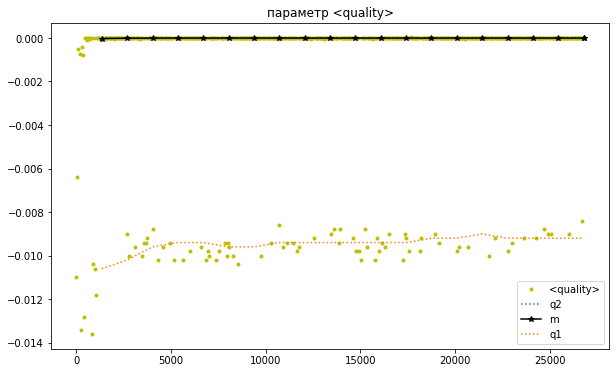

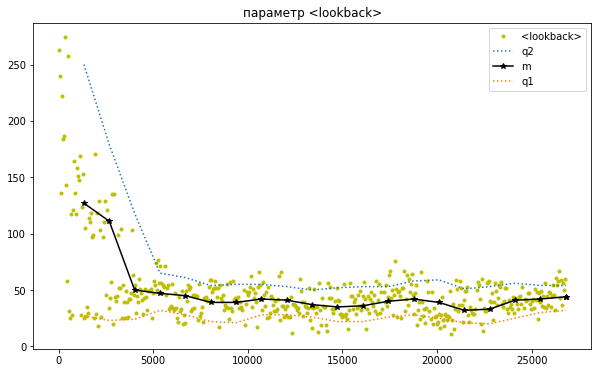

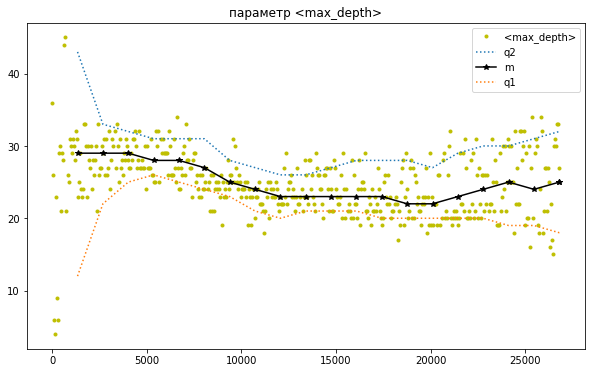

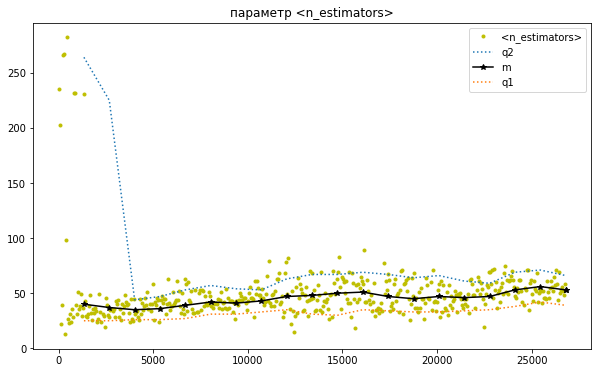

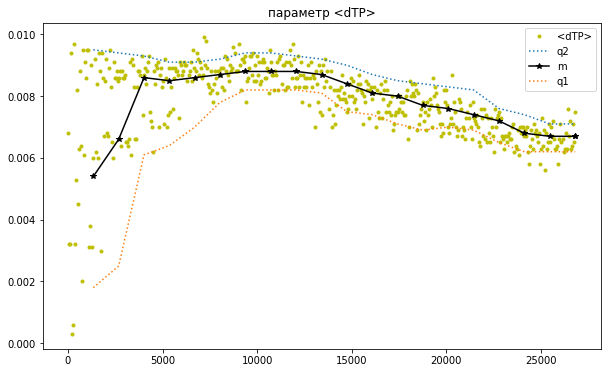

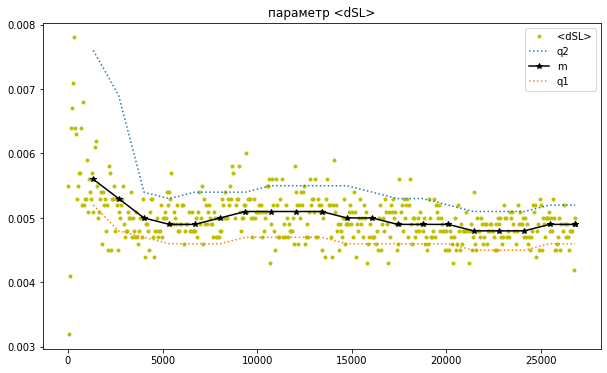

In [25]:
modelGA.plot_hist_new(('quality','lookback','max_depth','n_estimators','dTP','dSL'))

In [26]:
for n,h in enumerate(modelGA._hist):
    if h['new']['quality'] > 0:
        print(n,h['new'])


Выходные данные были обрезаны до нескольких последних строк (5000).
9491 {'quality': 1.6046511627906974e-05, 'lookback': 31, 'max_depth': 26, 'n_estimators': 46, 'dTP': 0.009, 'dSL': 0.0051}
9492 {'quality': 3.032659409020218e-06, 'lookback': 37, 'max_depth': 26, 'n_estimators': 38, 'dTP': 0.0091, 'dSL': 0.0052}
9497 {'quality': 7.418856259659968e-06, 'lookback': 19, 'max_depth': 19, 'n_estimators': 41, 'dTP': 0.0096, 'dSL': 0.0049}
9499 {'quality': 6.065318818040435e-06, 'lookback': 38, 'max_depth': 19, 'n_estimators': 42, 'dTP': 0.0089, 'dSL': 0.005}
9501 {'quality': 3.260869565217392e-06, 'lookback': 36, 'max_depth': 24, 'n_estimators': 53, 'dTP': 0.0094, 'dSL': 0.0052}
9502 {'quality': 9.546165884194054e-06, 'lookback': 57, 'max_depth': 20, 'n_estimators': 56, 'dTP': 0.0088, 'dSL': 0.0054}
9504 {'quality': 6.697819314641744e-06, 'lookback': 44, 'max_depth': 25, 'n_estimators': 39, 'dTP': 0.0086, 'dSL': 0.0053}
9505 {'quality': 6.346749226006191e-06, 'lookback': 22, 'max_depth': 25,

## Параметры лучшей

In [27]:
best_par = modelGA.getBestParams()
best_par

{'dSL': 0.0048,
 'dTP': 0.0068,
 'lookback': 47,
 'max_depth': 27,
 'n_estimators': 53}